# CSE527 Homework 3 - Part 3
**Due date: 23:59 on Nov 10, 2024**


## Description
---
Segmentation has been recently gaining more popularity in the field of computer vision. In this homework you will be implementing a standard UNet model to perform semantic segmentation. While transofrmer based architectures have demostrated impressive perfromance in semantic/instance segmentation, it's important to be familiar with other architectures commonly used for semantic segmentation.

You will use the same dataset that you have used in part 2 of this homework, but the output of the model here is a class level segmentation mask.

Input of the model will be an RGB image (3xHxW) and output will be a boolean mask (HxW).

| Input Image      | Output Mask (class:horse) |
| ----------- | ----------- |
| ![Input Image](https://drive.google.com/uc?id=1BqmNxzV4t5MFQHjBFizlI1p9xlEatXiz)| ![Output Image](https://drive.google.com/uc?id=1NCW95D8JDBNsgzfFNa14ZiV_SiCpBPIv)|

  
Read the paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation
](https://arxiv.org/abs/1505.04597) to understand the structure of UNet models, what they are composed of, and how to build them.  

Also you should refer to this github repo to understand the implementations of a UNet: [milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet) . Specifically refer to unet/unet_model.py to gain understanding of the convolutional blocks, and skip connections.

In this part you will be designing UNet architecture simmilar to it but with specific changes.

## Code
---


In [ ]:
HW3_ROOT_PATH = 'hw3/'
PATH_TO_PART3 = HW3_ROOT_PATH + 'part3/'
PATH_TO_COCO = HW3_ROOT_PATH + 'coco/'


You will be using this code [unet.zip](https://drive.google.com/file/d/1p2tMMUfF2vfcr3QHipJx0XyiBOMWoMNM/view?usp=sharing) to complete your work. This code contains all the tools for loading dataset, training the newtorks, loss methods and evaluation metrics.


To pull this code into your drive, you have to first add the zip file as shortcut to current working directory (PATH_TO_PART3 above). To do this, open the above link and click on "Add shortcut to Drive" button (drive symbol with a plus) and navigate to working PATH_TO_PART3 directory and add shortcut.


We will use the same dataset that you have used in the Part 2 : [coco.zip dataset](https://drive.google.com/file/d/1GVyxYHwVgiG9z_Sn46wslT_2n65DLZRw/view?usp=sharing). Put this in the root of your hw3 HW3_ROOT_PATH. If you have this extracted to some path you can re-use the it.


In [ ]:
# CD into root of your homework2 part3 directory
%cd -q $HW3_ROOT_PATH
!mkdir -p '{PATH_TO_PART3}'
%cd $PATH_TO_PART3

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1bE0lnMcU5RVsE1jbQeewCCLiA3JIkFL2/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/part3


In [ ]:
!ls

CSE527_24F_HW3_P3.ipynb  unet  unet.zip


In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-xk0wpz4n
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-xk0wpz4n
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=376060 sha256=82b57eef9ed3a0983ca83cd2e7fed9bc37c6fa03bcc83607fc187c2bbdff788a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wjtl8pt7/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8


In [ ]:
!unzip -n ../coco.zip -d ..

Archive:  ../coco.zip
Archive:  unet.zip


In [ ]:
%cd -q unet
!ls

coco.py  concat_checkpoint.pth	images	main.py  __pycache__  transforms.py  unet.py  util


### Load helper method

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

def show_images(folder_path):
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_paths = image_paths[:50]
    rows = 5
    cols = 10
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    for i, image_path in enumerate(image_paths):
        image = plt.imread(image_path)
        row = int(i / cols)
        col = i % cols
        axes[row, col].imshow(image)
        axes[row, col].set_title(os.path.basename(image_path))
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

## Training
---
You will use main.py for training, evaluating and visualizing.



In [ ]:
!python main.py --help

device cuda
usage: main.py [-h] [--coco_path COCO_PATH] [--batch_size BATCH_SIZE] [--epochs EPOCHS] [--eval]
               [--load_pretrained] [--skip {concat,sum}] [--checkpoint CHECKPOINT]

Train a segmentation model on COCO data.

options:
  -h, --help            show this help message and exit
  --coco_path COCO_PATH
                        Path to COCO dataset directory.
  --batch_size BATCH_SIZE
                        Batch size for training.
  --epochs EPOCHS       Epochs for training.
  --eval                Whether to evaluate the model on the validation set.
  --load_pretrained     Whether to evaluate the model on the validation set.
  --skip {concat,sum}   Skip connection strategy: either concatenation (concat) or summation
                        (sum).
  --checkpoint CHECKPOINT
                        Path to checkpoint file.


##Implement UNet (10 points)
---


`unet.py` contains two classes `UNet()` and `SumUNet()`, both are implementations of `torch.nn.Module()`.

You need to complete the methods `UNet:__init__()` and `UNet:forward()` to implement a segmentation architecture that processes input of shape `N x 3 x H x W` (N is batch size) and will output a mask of shape `N x 1 x H x W`

###Requirements
1. Encoder part of the UNet will be made of pytorch Resnet's layers 1 to 4.

    https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html

    Essentially, your UNet's encoder will be using `torchvision.models.resnet`'s `layer1, layer2, layer3, layer4` for downsampling.

2. When argument `load_pretrained_encoder_layers` of __init__() is set to true, the layers will be initialized with the pretrained weights. You can use the default pre-trained weights provided by pytorch.

3. As described in the paper or above repo, `concatenation` operations will be done for the skip connections. (in the upcoming section, you will instead use summation)


Note:
- You are recommended to size your model under 25M paramenters. As more parameters will hurt the trainig time and even effeciency.
- For the decoder section (later half), you will not be able to use any pre-trained weights, so you will use randomly initialized blocks (that you will design on your own). Each block usually have layers of `[Conv, BatchNorm, ReLu]`
- You need not use any ReLU on the last mask output layer.

Hint:
- chose a [resnet](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html) size
- understand the `In` channels & `Out` channels of each layer of your chosen resnet()
- build decoder layers so that they will work along the above 4 layers
- conclude how to use the skip connections. ( you will using `concatenation`).
- complete the forward() method
- use print(x.shape) statements to understand the flow of tensors

Log reference: [log](https://drive.google.com/file/d/1ZGd-ciOKkajri0GEOwc-uJDBjGJHJdNY/view?usp=drive_link)

Aim for mIoU more than 0.35. You may not be penalized for low perfromance of your model.  



In [ ]:
!python main.py --skip concat --coco_path "{PATH_TO_COCO}"

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=False, load_pretrained=False, skip='concat', checkpoint='concat_checkpoint.pth')
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Epoch: [0]  [ 0/25]  eta: 0:03:08    time: 7.5340  data: 5.0160  max mem: 11727
Epoch: [0]  [10/25]  eta: 0:01:23    time: 5.5853  data: 4.8587  max mem: 11750
Epoch: [0]  [20/25]  eta: 0:00:27    time: 5.3219  data: 4.7711  max mem: 11750
Epoch: [0]  [24/25]  eta: 0:00:05    time: 5.2419  data: 4.6891  max mem: 11750
Epoch: [0] Total time: 0:02:14 (5.3712 s / it)
train: dice: 0.759457, bce: 0.622568, loss: 0.667741
LR 0.0005
Epoch: [0]  [0/3]  eta: 0:00:13    time: 4.6390  data: 3.9675  max mem: 11750
Epoch: [0]  [2/3]  eta: 0:00:03    time: 3.9845  data: 3.4854  max mem: 11750
Epoch: [0] Total time: 

### Evaluation
To just run the evaluation or to produce the predicted masks in the `images/` folder, you need to run the main.py with --eval.
Note that this will load the latest stored checkpoint corresponding to the --skip flag that you have provided.

In [ ]:
!python main.py --skip concat --coco_path "{PATH_TO_COCO}" --eval

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=True, load_pretrained=False, skip='concat', checkpoint='concat_checkpoint.pth')
/gdrive/.shortcut-targets-by-id/1bE0lnMcU5RVsE1jbQeewCCLiA3JIkFL2/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/part3/unet/main.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torc

### With --load_pretrained

When properly configured using pre-trained weights should result in higher mIoUs. You can expect mIoU around .65  

In [ ]:
!python main.py --skip concat --coco_path "{PATH_TO_COCO}"  --load_pretrained

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=False, load_pretrained=True, skip='concat', checkpoint='concat_checkpoint.pth')
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 163MB/s]
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [ 0/25]  eta: 0:00:53    time: 2.1412  data: 0.5465  max mem: 11727
Epoch: [0]  [10/25]  eta: 0:00:19    time: 1.2966  data: 0.5757  max mem: 11750
Epoch: [0]  [20/25]  eta: 0:00:06    time: 1.2330  data: 0.5761  max mem: 11750
Epoch: [0]  [24/25]  eta: 0:00:01    time: 1.2537  data: 0.5779  max mem: 11750
Epoch: [0] Total time: 0:00:31 (1.2762 s / it)
train: dice: 0.722180, bce: 0.604302, loss: 0.643202
LR 0.0005
Epoch: 

In [ ]:
!python main.py --skip concat --coco_path "{PATH_TO_COCO}" --eval

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=True, load_pretrained=False, skip='concat', checkpoint='concat_checkpoint.pth')
/gdrive/.shortcut-targets-by-id/1bE0lnMcU5RVsE1jbQeewCCLiA3JIkFL2/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/part3/unet/main.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torc

Let us see the masks generated by the best run:
It is okay if the masks are not perfectly aligned. We are only training over 500 images for a short duration!

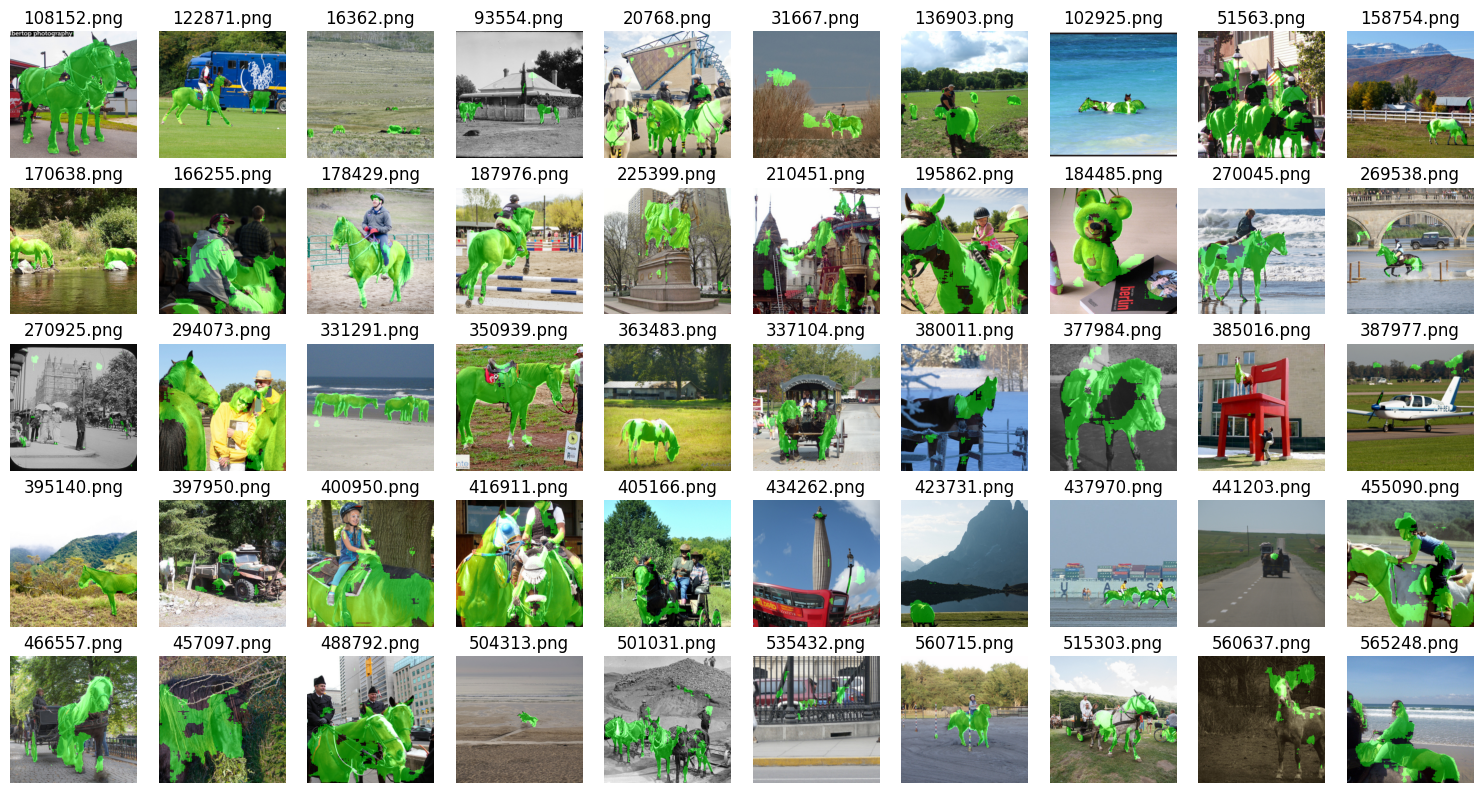

In [ ]:
folder_path = 'images'
show_images(folder_path)

##Implement SumUNet (10 points)
---
This is very much similar to above UNet, but for the skip connections we will be using summation operation instead of concatenation. This is kind of an open ended question, in the sense that there are multuple ways you can design connections.

Feel free to use any layers | blocks | up/down sampling.


Hint:
- Again you need to focus on the feature shapes
- you can use sampling techniques to change the height/width
- you can use conv layers to change number of channels  

Note: You can chose to remove --load_pretrained from the below cell if you think that will have a better perfromance


In [14]:
!python main.py --skip sum --coco_path "{PATH_TO_COCO}"  --load_pretrained

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=False, load_pretrained=True, skip='sum', checkpoint='sum_checkpoint.pth')
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch: [0]  [ 0/25]  eta: 0:00:59    time: 2.3739  data: 0.7546  max mem: 10335
Epoch: [0]  [10/25]  eta: 0:00:18    time: 1.2133  data: 0.5658  max mem: 10347
Epoch: [0]  [20/25]  eta: 0:00:05    time: 1.1251  data: 0.5741  max mem: 10347
Epoch: [0]  [24/25]  eta: 0:00:01    time: 1.1402  data: 0.5849  max mem: 10347
Epoch: [0] Total time: 0:00:29 (1.1866 s / it)
train: dice: 0.717001, bce: 0.514839, loss: 0.581552
LR 0.0005
Epoch: [0]  [0/3]  eta: 0:00:03    time: 1.1844  data: 0.3181  max mem: 10347
Epoch: [0]  [2/3]  eta: 0:00:00    time: 0.7737  data: 0.2627  max mem: 10347
Epoch: [0] Total time: 0:00:02

In [15]:
!python main.py --skip sum --coco_path "{PATH_TO_COCO}"  --eval

device cuda
Namespace(coco_path='/gdrive/MyDrive/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/coco/', batch_size=20, epochs=20, eval=True, load_pretrained=False, skip='sum', checkpoint='sum_checkpoint.pth')
/gdrive/.shortcut-targets-by-id/1bE0lnMcU5RVsE1jbQeewCCLiA3JIkFL2/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/part3/unet/main.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

## Submission guidelines
---



The submission structure should look like:

***IMPORTANT: Remove the images/ folder, and any CHECKPOINT files.***


```
{last name}_{first name}_{sbu id}_hw3/
├── part1/
│   └── ...
├── part2/
│   └── ...
├── part3/
│   ├── CSE527_24F_HW3_P3.ipynb
│   └── unet/
│       ├── utils/
│       │   ├── ...
│       │   └── ...
│       ├── coco.py
│       ├── main.py
│       ├── transforms.py
│       └── unet.py
```


Follow instructions in part1's submission guidelines to generate your complete submission